In [1]:
import sys
from pathlib import Path
import json

import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.providers.aer import StatevectorSimulator
from qiskit.circuit.library import ZZFeatureMap
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter
from pandas import DataFrame

sys.path.extend(['/home/quic/QUIC-Projects/'])
from classifiers.quantum.qml.qasvm import PseudoTensorSoftQASVM
from classifiers.datasets.sklearn import SklearnDataset
from classifiers.quantum.ansatz import MultilayerCircuit9FeatureMap
from classifiers.convex.svm import CvxSoftQASVM

In [2]:
# simulation setting
test_size = 2**10
n_steps = 2**10
stepsize = 0.001
n_feature = 10
n_qubits_list = np.arange(6, 13+1, dtype=int) # 6 7 8 9 10 11 12 13
n_layers_list = np.arange(1, 15+1, 2, dtype=int) # 1 3 5 7 9 11 13 15
C=10**3
lamda=10**3
dir_name = 'numerical_simulation'
sampling_seed=80531

In [7]:
def load_train_and_test_data(dataset, train_size:float=2**13, test_size:float=2**7):
    data = dataset.data.to_numpy()
    label = dataset.target.to_numpy().astype(float)
    mask = (label==0) + (label==1)
    data = data[mask]
    label = label[mask]
    X_train, X_test, y_train, y_test = train_test_split(data, label, train_size=train_size, test_size=test_size, random_state=sampling_seed)
    return X_train, y_train, X_test, y_test

def reduce_and_normalize_data(n_components, X_train, X_test):
    scaler = StandardScaler()
    pca = PCA(n_components=n_components)
    X_train = scaler.fit_transform(X_train)
    X_train = pca.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_test = pca.transform(X_test)
    for i, d in enumerate(X_train):
        X_train[i] = d/np.linalg.norm(d)
    for i, d in enumerate(X_test):
        X_test[i] = d/np.linalg.norm(d)
    return X_train, X_test

def construct_training_and_test_quantum_kernel_matrix(feature_map:QuantumCircuit, X_train:np.ndarray, X_test:np.ndarray):
    quantum_instance = QuantumInstance(backend = StatevectorSimulator())
    quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance, enforce_psd=False)
    training_kernel = quantum_kernel.evaluate(X_train, X_train)
    test_kernel = quantum_kernel.evaluate(X_train, X_test)
    return training_kernel, test_kernel

def train_and_test_reference(cvxsvm:CvxSoftQASVM, train_kernel:np.ndarray, test_kernel:np.ndarray, y_train:np.ndarray, y_test:np.ndarray):
    cvxsvm.fit(train_kernel, y_train)
    fvec = cvxsvm.f(test_kernel.T)
    accuarcy = cvxsvm.accuracy(test_kernel.T, y_test)
    cost = cvxsvm.dual_objective_value
    return fvec, accuarcy, cost

def epsilon(fvec, true_fvec):
    return np.sqrt(np.mean(np.abs(fvec-true_fvec)**2)).item()

def make_figure(df:DataFrame):
    fig, ax = plt.subplots()
    mappable = ax.imshow(df, cmap='binary')
    ax.set_xlabel('n_qubits')
    ax.set_ylabel('n_layers')
    ax.set_xticks(np.arange(len(n_qubits_list)))
    ax.set_yticks(np.arange(len(n_layers_list)))
    ax.set_xticklabels(n_qubits_list)
    ax.set_yticklabels(n_layers_list)
    fig.colorbar(mappable)
    return fig

In [4]:
# setting
dir_path = Path.cwd() / dir_name
dir_path.mkdir(parents=True, exist_ok=True)
dataset = fetch_openml('mnist_784')
print('loaded mnist data set')

loaded mnist data set


In [5]:
epsilon_summary = DataFrame({n_qubits:dict(zip(n_layers_list, np.zeros_like(n_layers_list))) for n_qubits in n_qubits_list}, dtype=float)
delta_summary = DataFrame({n_qubits:dict(zip(n_layers_list, np.zeros_like(n_layers_list))) for n_qubits in n_qubits_list}, dtype=float)
accuracy_summary = DataFrame({n_qubits:dict(zip(n_layers_list, np.zeros_like(n_layers_list))) for n_qubits in n_qubits_list}, dtype=float)

summary_writer = SummaryWriter(log_dir=dir_path)
for n_qubits in n_qubits_list:
    sub_dir_path = dir_path / f'n_qubits={n_qubits}'
    sub_dir_path.mkdir(parents=True, exist_ok=True)
    # data loading
    train_size = 2**n_qubits
    X_train, y_train, X_test, y_test = load_train_and_test_data(dataset, train_size=train_size, test_size=test_size)
    X_train, X_test = reduce_and_normalize_data(n_feature, X_train, X_test)
    feature_map = ZZFeatureMap(feature_dimension=n_feature, reps=3, entanglement='linear')
    train_kernel, test_kernel = construct_training_and_test_quantum_kernel_matrix(feature_map=feature_map, X_train=X_train, X_test=X_test)
    print(f'{train_size} X {train_size} train kernel matrix and {train_size} X {test_size} test kernel matrix generated')

    # set reference
    cvxsvm = CvxSoftQASVM(kernel='precomputed', C=C, lamda=lamda)
    true_fvec, true_accuarcy, true_cost = train_and_test_reference(cvxsvm, train_kernel, test_kernel, y_train, y_test)
    summary_writer.add_scalar('Reference/Accuracy', true_accuarcy, n_qubits)
    summary_writer.add_scalar('Reference/Minimized_Cost', true_cost, n_qubits)

    # save data and reference
    np.save(sub_dir_path/'X_train.npy', X_train)
    np.save(sub_dir_path/'X_test.npy', X_test)
    np.save(sub_dir_path/'y_train.npy', y_train)
    np.save(sub_dir_path/'y_test.npy', y_test)
    np.save(sub_dir_path/'train_kernel.npy', train_kernel)
    np.save(sub_dir_path/'test_kernel.npy', test_kernel)
    with open(sub_dir_path/'reference.json', 'w') as fp:
        json.dump(dict(
            accuracy=true_accuarcy, last_cost = true_cost, fvec=true_fvec
        ), fp=fp, default=list)

    # ansatz setup
    device:qml.Device = qml.device('lightning.qubit', wires=n_qubits)
    def var_form(params):
        qml.BasicEntanglerLayers(params, wires=device.wires, rotation=qml.RY)
    for n_layers in n_layers_list:
        sub_sub_dir_path = sub_dir_path / f'n_layers={n_layers}'
        sub_sub_dir_path.mkdir(parents=True, exist_ok=True)
        writer = SummaryWriter(log_dir=sub_sub_dir_path)
        # training
        parameter_shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=device.num_wires)
        qasvm = PseudoTensorSoftQASVM(data=train_kernel, label=y_train, C=C, lamda=lamda, device=device, feature_map=None, var_form=var_form)
        params=qml.numpy.random.random(parameter_shape, requires_grad=True)
        opt = qml.AdamOptimizer(stepsize=stepsize)
        cost_list = []
        for step in range(1, n_steps+1):
            params, cost = opt.step_and_cost(qasvm.cost_fn, params)
            cost_list.append(cost.item())
            if writer is not None:
                writer.add_scalar('Training/Cost', cost_list[-1], step)
                writer.add_scalar('Training/Normal_Cost', (cost_list[-1]-true_cost)/(cost_list[0]-true_cost), step)
        # test
        cost = qasvm.cost_fn(params.numpy()).item()
        fvec = qasvm.f(test_kernel, params.numpy()).numpy()
        accuracy = accuracy_score(np.where(fvec>0, 1, 0), y_test)
        epsilon_summary[n_qubits][n_layers] = epsilon(fvec, true_fvec)
        delta_summary[n_qubits][n_layers] = cost-true_cost
        accuracy_summary[n_qubits][n_layers] = accuracy
        summary_writer.add_figure('Test/epsilon', make_figure(epsilon_summary))
        summary_writer.add_figure('Test/delta', make_figure(delta_summary))
        summary_writer.add_figure('Test/accuracy', make_figure(accuracy_summary))
        # save result
        with open(sub_sub_dir_path/'result.json', 'w') as fp:
            json.dump(dict(
                accuracy=accuracy, last_cost = cost, fvec=fvec, cost_list=cost_list
            ), fp=fp, default=list)
        epsilon_summary.to_csv(dir_path/'epsilon_summary')
        delta_summary.to_csv(dir_path/'delta_summary')
        accuracy_summary.to_csv(dir_path/'accuracy_summary')


64 X 64 train kernel matrix and 64 X 1024 test kernel matrix generated
128 X 128 train kernel matrix and 128 X 1024 test kernel matrix generated
256 X 256 train kernel matrix and 256 X 1024 test kernel matrix generated
512 X 512 train kernel matrix and 512 X 1024 test kernel matrix generated
1024 X 1024 train kernel matrix and 1024 X 1024 test kernel matrix generated
2048 X 2048 train kernel matrix and 2048 X 1024 test kernel matrix generated
4096 X 4096 train kernel matrix and 4096 X 1024 test kernel matrix generated
8192 X 8192 train kernel matrix and 8192 X 1024 test kernel matrix generated


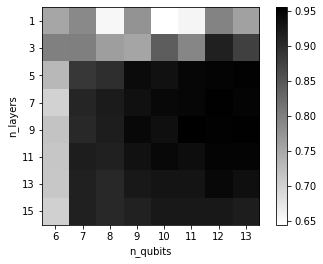

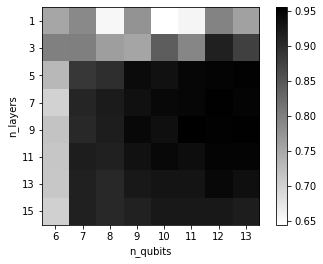

In [10]:
make_figure(accuracy_summary)

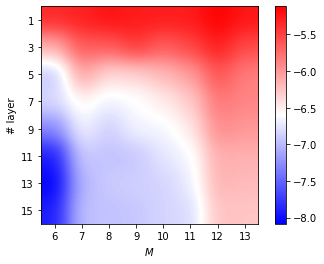

In [24]:
fig, ax = plt.subplots()
mappable = ax.imshow(np.log(epsilon_summary), cmap='bwr', interpolation='gaussian')
ax.set_xlabel(r'$M$')
ax.set_ylabel('# layer')
ax.set_xticks(np.arange(len(n_qubits_list)))
ax.set_yticks(np.arange(len(n_layers_list)))
ax.set_xticklabels(n_qubits_list)
ax.set_yticklabels(n_layers_list)
fig.colorbar(mappable)

In [26]:
N_qubits, N_layers = np.meshgrid(n_qubits_list, n_layers_list)
N_qubits, N_layers

(array([[ 6,  7,  8,  9, 10, 11, 12, 13],
        [ 6,  7,  8,  9, 10, 11, 12, 13],
        [ 6,  7,  8,  9, 10, 11, 12, 13],
        [ 6,  7,  8,  9, 10, 11, 12, 13],
        [ 6,  7,  8,  9, 10, 11, 12, 13],
        [ 6,  7,  8,  9, 10, 11, 12, 13],
        [ 6,  7,  8,  9, 10, 11, 12, 13],
        [ 6,  7,  8,  9, 10, 11, 12, 13]]),
 array([[ 1,  1,  1,  1,  1,  1,  1,  1],
        [ 3,  3,  3,  3,  3,  3,  3,  3],
        [ 5,  5,  5,  5,  5,  5,  5,  5],
        [ 7,  7,  7,  7,  7,  7,  7,  7],
        [ 9,  9,  9,  9,  9,  9,  9,  9],
        [11, 11, 11, 11, 11, 11, 11, 11],
        [13, 13, 13, 13, 13, 13, 13, 13],
        [15, 15, 15, 15, 15, 15, 15, 15]]))

In [28]:
N_params = N_qubits*N_layers
N_params

array([[  6,   7,   8,   9,  10,  11,  12,  13],
       [ 18,  21,  24,  27,  30,  33,  36,  39],
       [ 30,  35,  40,  45,  50,  55,  60,  65],
       [ 42,  49,  56,  63,  70,  77,  84,  91],
       [ 54,  63,  72,  81,  90,  99, 108, 117],
       [ 66,  77,  88,  99, 110, 121, 132, 143],
       [ 78,  91, 104, 117, 130, 143, 156, 169],
       [ 90, 105, 120, 135, 150, 165, 180, 195]])

In [31]:
epsilon_summary.to_numpy()

array([[0.00471873, 0.004949  , 0.00543618, 0.0051349 , 0.00508594,
        0.00510384, 0.00599926, 0.0052564 ],
       [0.00212361, 0.00358847, 0.00349589, 0.00435901, 0.00344922,
        0.00398836, 0.00505599, 0.00386247],
       [0.00096975, 0.00237145, 0.00167142, 0.00173082, 0.00203328,
        0.00238197, 0.00372585, 0.00286262],
       [0.00109809, 0.00145048, 0.00123956, 0.00133994, 0.00151701,
        0.00182314, 0.00301032, 0.00275267],
       [0.00067434, 0.00127601, 0.00101293, 0.00127484, 0.0012791 ,
        0.00153509, 0.00266915, 0.0024746 ],
       [0.00035746, 0.00100716, 0.00095052, 0.00097553, 0.00117643,
        0.00129254, 0.00220087, 0.00213999],
       [0.00030796, 0.00088832, 0.00101003, 0.00103195, 0.00105529,
        0.00121717, 0.00213037, 0.00202207],
       [0.00036219, 0.00094288, 0.00095595, 0.00098169, 0.00106784,
        0.00109127, 0.00193562, 0.00189362]])

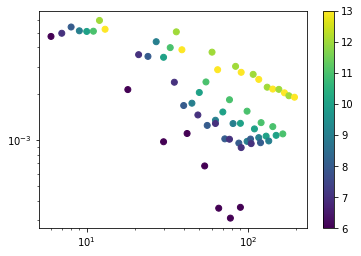

In [35]:
plt.scatter(N_params.flatten(), epsilon_summary.to_numpy().flatten(), c=N_qubits.flatten())
plt.colorbar()
plt.xscale('log')
plt.yscale('log')

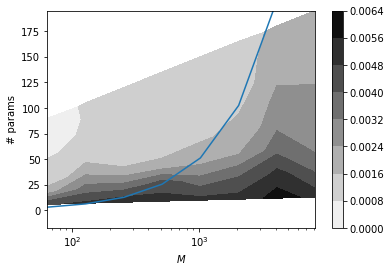

In [97]:
plt.contourf(2**N_qubits, N_params, epsilon_summary, cmap='binary')
plt.plot((2**N_qubits)[0], ((2**N_qubits))[0]/20)
plt.colorbar()
plt.ylabel('# params')
plt.ylim([None, np.max(N_params)])
plt.xlabel(r'$M$')
plt.xscale('log')